In [1]:
addprocs(8)

8-element Array{Int64,1}:
 2
 3
 4
 5
 6
 7
 8
 9

In [1]:
@everywhere using GaussianProcesses, PGFPlots, SumProductNetworks
using StatsFuns, Distributions, ProgressMeter#, MultivariateStats
import SumProductNetworks.add!

include("utilFunctions.jl")
include("dataTypes.jl")
include("dataTypeUtilFunctions.jl")
include("computationFunctions.jl")
include("regionGraph.jl")
include("regionGraphUtils.jl")
include("gpUtils.jl")

optimize2! (generic function with 1 method)

In [3]:
# todo if wifi access
# Pkg.add("MultivariateStats")

Load the data set

In [2]:
Xtrain = readdlm("../data/kin40k/kin40k_train_data.asc");
ytrain = readdlm("../data/kin40k/kin40k_train_labels.asc");

@everywhere Xtest = readdlm("../data/kin40k/kin40k_test_data.asc");
ytest = readdlm("../data/kin40k/kin40k_test_labels.asc");

In [3]:
println("size of training set: ", size(Xtrain))
println("size of test set: ", size(Xtest))

size of training set: (10000, 8)
size of test set: (30000, 8)


## first train a full GP

In [4]:
(N, D) = size(Xtrain)

(10000, 8)

In [12]:
mZero = MeanZero()
kern = SEArd(ones(D) * -1.0, 0.0) 
logObsNoise = -1.0 

gp_1 = GP(Xtrain', vec(ytrain[:,1]), mZero, kern, logObsNoise)

GP Exact object:
  Dim = 8
  Number of observations = 10000
  Mean function:
    Type: GaussianProcesses.MeanZero, Params: Float64[]
  Kernel:
    Type: GaussianProcesses.SEArd, Params: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0]
  Input observations = 
[1.55196 -0.926986 … 1.20313 0.114388; 0.588773 0.728307 … 0.0646877 -1.27875; … ; -1.39825 -1.40968 … -0.309747 -0.120185; -0.369625 -0.661783 … 1.39161 -0.833536]
  Output observations = [0.576374, 1.52419, 1.29829, -0.423155, -1.36133, -1.58375, -1.13279, -0.521397, 0.664089, 2.57016  …  0.663839, 1.31747, 0.531289, 0.673854, 0.212291, 0.665228, -0.22594, -2.1395, 0.229985, -0.328763]
  Variance of observation noise = 0.1353352832366127
  Marginal Log-Likelihood = -13910.778

In [5]:
# optimal parameters for a full GP (using GPy)

llns = log.([2.47722379, 2.30587632, 1.33572130, 1.48040323, 1.57384943, 1.13716216, 1.17033525, 1.66758805])
klnoise = log(1.0221786984735717)
lnoise = log(0.0021675853958968484)

-6.134141451748025

## Data from Deisenroth

In [2]:
# product of expert
x_num_experts = [64, 16, 4, 1]
x_plot = [156, 625, 2500, 10000]
y_poe = [0.5181503889369059, 0.2852348026505329, 0.16053490828771722, 0.1]

# Bayesian committee machine
y_bmc = [0.45148372227023914, 0.2698549889561126, 0.16053490828771722, 0.1]

# robust Bayesian committee machine (Deisenroth & Ng)
y_dgp = [0.3950734658599827, 0.2519062710073946, 0.1605301065975223, 0.1]

4-element Array{Float64,1}:
 0.395073
 0.251906
 0.16053 
 0.1     

Results from SPN_GP

In [3]:
x_spn = [843.6836158192091, 2482.593263626285, 10000]
y_spn = [0.15018165986485818, 0.13802102294979657, 0.1]

3-element Array{Float64,1}:
 0.150182
 0.138021
 0.1     

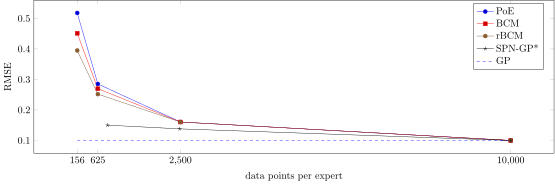

In [6]:
p = PGFPlots.Axis([
        PGFPlots.Linear(x_plot, y_poe, legendentry="PoE"),
        PGFPlots.Linear(x_plot, y_bmc, legendentry="BCM"),
        PGFPlots.Linear(x_plot, y_dgp, legendentry="rBCM"),
        PGFPlots.Linear(x_spn, y_spn, legendentry="SPN-GP*"),
        PGFPlots.Linear([156, 10000], [0.1, 0.1], legendentry="GP", style="dashed", mark="none")
        ],
    width="20cm", height="7cm",
    xlabel="data points per expert", ylabel="RMSE", style="xtick={156,625,2500,10000}, scaled x ticks = false")

PGFPlots.save("../plots/kin40k.pdf", p)
p

## SPN-GP

In [ ]:
global gID = 1

numSums = 1
meanFunction = MeanZero();
kernelFunctions = [SEArd(llns, klnoise)]

kernelPriors = []

noise = lnoise;

# data range
minX = vec(minimum(Xtrain, 1)) - 0.1
maxX = vec(maximum(Xtrain, 1)) + 0.1

# split size
δ = (maxX - minX) ./ 8

# maximum depth
max_depth = 4
min_samples = 156

overlap = 0.05

(rootRegion, sumRegions, gpRegions, allPartitions) = poonDomingos_ND(δ, minX, maxX, max_depth, min_samples, Xtrain);

RegionIDs = Dict(r[2] => r[1] for r in enumerate(union(sumRegions, gpRegions)));
PartitionIDS = Dict(p[2] => p[1] + maximum(values(RegionIDs)) for p in enumerate(allPartitions));

remaining size: 3.1973357499999997 <= 0.45676225000000004 next depth! - 0
remaining size: 3.1973357499999997 > 0.45676225000000004
remaining size: 2.7405735 <= 0.45676225000000004 next depth! - 0
remaining size: 2.7405735 > 0.45676225000000004
remaining size: 2.2838112500000003 > 0.45676225000000004
remaining size: 2.2838112500000003 > 0.45676225000000004
remaining size: 1.827049 > 0.45676225000000004
remaining size: 1.827049 > 0.45676225000000004
remaining size: 1.3702867499999998 > 0.45676225000000004
remaining size: 1.3702867499999998 > 0.45676225000000004
remaining size: 0.9135245000000001 > 0.45676225000000004
remaining size: 0.9135245000000001 <= 0.45676225000000004 next depth! - 0
remaining size: 0.4567622499999999 > 0.45676225000000004
remaining size: 0.4567622499999999 <= 0.45676225000000004 next depth! - 0
Samples in expert: 0
remaining size: -2.220446049250313e-16 > 0.45676225000000004
remaining size: -2.220446049250313e-16 <= 0.45676225000000004 next depth! - 0
remaining si

Samples in expert: 82
remaining size: 0.9070442500000002 > 0.453522125
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
Samples in expert: 152
Samples in expert: 40
remaining size: 0.4535221250000001 > 0.453522125
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 32
Samples in expert: 129
remaining size: 1.3605663750000003 <= 0.453522125 next depth! - 2
remaining size: 1.3605663750000003 > 0.453522125
Samples in expert: 79
Samples in expert: 82
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
Samples in expert: 121
Samples in expert: 40
remaining size: 0.45352212500000033 > 0.453522125
remaining size: 0.45352212500000033 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: 2.220446049250313e-16 > 0.453522125
remaining size: 2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert: 42
Samples in expert: 143
remaining size: 1.

remaining size: 1.3605663749999999 <= 0.453522125 next depth! - 2
remaining size: 1.3605663749999999 > 0.453522125
Samples in expert: 117
Samples in expert: 68
remaining size: 0.90704425 > 0.453522125
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 148
Samples in expert: 37
remaining size: 0.4535221249999999 > 0.453522125
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
Samples in expert: 24
Samples in expert: 148
remaining size: 1.8140885000000002 <= 0.453522125 next depth! - 2
remaining size: 1.8140885000000002 > 0.453522125
Samples in expert: 61
Samples in expert: 111
remaining size: 1.360566375 <= 0.453522125 next depth! - 2
remaining size: 1.360566375 > 0.453522125
Samples in expert: 98
Samples in expert: 74
remaining size: 0.9070442500000002 > 0.453522125
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
Samples in expert: 141
Samples in expert: 31
remaining size: 0.4535221250000001 > 0.453522125
remaining size: 0.4535

Samples in expert: 42
remaining size: 0.4535221249999999 > 0.453522125
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
Samples in expert: 42
Samples in expert: 114
remaining size: 1.3605663749999999 <= 0.453522125 next depth! - 2
remaining size: 1.3605663749999999 > 0.453522125
Samples in expert: 77
Samples in expert: 79
remaining size: 0.9070442499999999 <= 0.453522125 next depth! - 2
remaining size: 0.9070442499999999 <= 0.453522125 next depth! - 2
Samples in expert: 114
Samples in expert: 42
remaining size: 0.453522125 > 0.453522125
remaining size: 0.453522125 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: -2.220446049250313e-16 > 0.453522125
remaining size: -2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert: 42
Samples in expert: 114
remaining size: 1.360566375 <= 0.453522125 next depth! - 2
remaining size: 1.360566375 > 0.453522125
Samples in expert: 77
Samples in expert: 79
remaining size: 0.9070442500000001 <= 0.4535221

remaining size: 0.90704425 > 0.453522125
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 38
remaining size: 0.45352212500000033 > 0.453522125
remaining size: 0.45352212500000033 <= 0.453522125 next depth! - 2
Samples in expert: 42
remaining size: 2.2676106249999997 <= 0.453522125 next depth! - 2
remaining size: 2.2676106249999997 > 0.453522125
Samples in expert: 70
remaining size: 1.8140884999999998 <= 0.453522125 next depth! - 2
remaining size: 1.8140884999999998 > 0.453522125
Samples in expert: 112
Samples in expert: 114
remaining size: 1.3605663749999999 > 0.453522125
remaining size: 1.3605663749999999 > 0.453522125
Samples in expert: 147
Samples in expert: 79
remaining size: 0.9070442499999998 > 0.453522125
remaining size: 0.9070442499999998 <= 0.453522125 next depth! - 2
Samples in expert: 42
remaining size: 0.45352212499999967 > 0.453522125
remaining size: 0.45352212499999967 <= 0.453522125 next depth! - 2
Samples in expert: 42
Samples in expert: 114


Samples in expert: 83
remaining size: 0.90704425 > 0.453522125
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 41
remaining size: 0.4535221249999999 > 0.453522125
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
Samples in expert: 48
Samples in expert: 151
remaining size: 1.8140885 <= 0.453522125 next depth! - 2
remaining size: 1.8140885 > 0.453522125
Samples in expert: 76
Samples in expert: 123
remaining size: 1.360566375 <= 0.453522125 next depth! - 2
remaining size: 1.360566375 > 0.453522125
Samples in expert: 120
Samples in expert: 79
remaining size: 0.9070442500000002 > 0.453522125
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
Samples in expert: 42
remaining size: 0.4535221250000001 > 0.453522125
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 48
Samples in expert: 109
remaining size: 1.3605663749999999 <= 0.453522125 next depth! - 2
remaining size: 1.3605663749999999 > 0.4535221

remaining size: -2.220446049250313e-16 > 0.453522125
remaining size: -2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert: 44
Samples in expert: 143
remaining size: 1.8140885000000002 <= 0.453522125 next depth! - 2
remaining size: 1.8140885000000002 > 0.453522125
Samples in expert: 81
Samples in expert: 106
remaining size: 1.3605663750000003 <= 0.453522125 next depth! - 2
remaining size: 1.3605663750000003 > 0.453522125
Samples in expert: 123
Samples in expert: 64
remaining size: 0.9070442500000003 > 0.453522125
remaining size: 0.9070442500000003 <= 0.453522125 next depth! - 2
Samples in expert: 23
remaining size: 0.4535221250000001 > 0.453522125
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 48
remaining size: 2.72113275 <= 0.453522125 next depth! - 2
remaining size: 2.72113275 > 0.453522125
Samples in expert: 76
remaining size: 2.267610625 <= 0.453522125 next depth! - 2
remaining size: 2.267610625 > 0.453522125
Samples in exper

Samples in expert: 0
remaining size: 1.1102230246251565e-16 > 0.453522125
remaining size: 1.1102230246251565e-16 <= 0.453522125 next depth! - 2
Samples in expert: 38
Samples in expert: 118
remaining size: 1.3605663749999999 <= 0.453522125 next depth! - 2
remaining size: 1.3605663749999999 > 0.453522125
Samples in expert: 78
Samples in expert: 78
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 114
Samples in expert: 42
remaining size: 0.4535221250000001 > 0.453522125
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 38
Samples in expert: 154
remaining size: 1.8140885 <= 0.453522125 next depth! - 2
remaining size: 1.8140885 > 0.453522125
Samples in expert: 78
Samples in expert: 114
remaining size: 1.3605663749999999 <= 0.453522125 next depth! - 2
remaining size: 1.3605663749999999 > 0.453522125
Samples in expert: 114
Samples in expert: 78
remaining size: 0.90704425000

remaining size: 0.9070442500000001 > 0.453522125
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
Samples in expert: 19
remaining size: 0.4535221249999999 > 0.453522125
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: 2.220446049250313e-16 > 0.453522125
remaining size: 2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert: 38
remaining size: 2.2676106249999997 <= 0.453522125 next depth! - 2
remaining size: 2.2676106249999997 > 0.453522125
Samples in expert: 78
Samples in expert: 133
remaining size: 1.8140885 <= 0.453522125 next depth! - 2
remaining size: 1.8140885 > 0.453522125
Samples in expert: 114
Samples in expert: 97
remaining size: 1.3605663749999999 > 0.453522125
remaining size: 1.3605663749999999 > 0.453522125
Samples in expert: 55
remaining size: 0.9070442499999999 > 0.453522125
remaining size: 0.9070442499999999 <= 0.453522125 next depth! - 2
Samples in expert: 19
remaining size: 0.4535221

remaining size: 0.90704425 > 0.453522125
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 24
remaining size: 0.45352212500000033 > 0.453522125
remaining size: 0.45352212500000033 <= 0.453522125 next depth! - 2
Samples in expert: 29
remaining size: 2.2676106249999997 <= 0.453522125 next depth! - 2
remaining size: 2.2676106249999997 > 0.453522125
Samples in expert: 65
Samples in expert: 131
remaining size: 1.8140884999999998 <= 0.453522125 next depth! - 2
remaining size: 1.8140884999999998 > 0.453522125
Samples in expert: 93
Samples in expert: 103
remaining size: 1.3605663749999999 > 0.453522125
remaining size: 1.3605663749999999 > 0.453522125
Samples in expert: 128
Samples in expert: 68
remaining size: 0.9070442499999998 > 0.453522125
remaining size: 0.9070442499999998 <= 0.453522125 next depth! - 2
Samples in expert: 40
remaining size: 0.45352212499999967 > 0.453522125
remaining size: 0.45352212499999967 <= 0.453522125 next depth! - 2
Samples in expert: 36
S

remaining size: 0.45352212499999967 > 0.453522125
remaining size: 0.45352212499999967 <= 0.453522125 next depth! - 2
Samples in expert: 25
Samples in expert: 151
remaining size: 2.267610625 <= 0.453522125 next depth! - 2
remaining size: 2.267610625 > 0.453522125
Samples in expert: 55
Samples in expert: 121
remaining size: 1.8140885 <= 0.453522125 next depth! - 2
remaining size: 1.8140885 > 0.453522125
Samples in expert: 91
Samples in expert: 85
remaining size: 1.360566375 > 0.453522125
remaining size: 1.360566375 > 0.453522125
Samples in expert: 125
Samples in expert: 51
remaining size: 0.90704425 > 0.453522125
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 153
Samples in expert: 23
remaining size: 0.4535221249999999 > 0.453522125
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
Samples in expert: 29
remaining size: 2.72113275 <= 0.453522125 next depth! - 2
remaining size: 2.72113275 > 0.453522125
Samples in expert: 54
Samples in expert: 1

Samples in expert: 35
remaining size: 2.72113275 <= 0.453522125 next depth! - 2
remaining size: 2.72113275 > 0.453522125
Samples in expert: 58
Samples in expert: 147
remaining size: 2.267610625 <= 0.453522125 next depth! - 2
remaining size: 2.267610625 > 0.453522125
Samples in expert: 80
Samples in expert: 125
remaining size: 1.8140885000000002 > 0.453522125
remaining size: 1.8140885000000002 > 0.453522125
Samples in expert: 109
Samples in expert: 96
remaining size: 1.360566375 > 0.453522125
remaining size: 1.360566375 > 0.453522125
Samples in expert: 138
Samples in expert: 67
remaining size: 0.90704425 > 0.453522125
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 29
remaining size: 0.45352212500000033 > 0.453522125
remaining size: 0.45352212500000033 <= 0.453522125 next depth! - 2
Samples in expert: 35
Samples in expert: 141
remaining size: 2.2676106249999997 <= 0.453522125 next depth! - 2
remaining size: 2.2676106249999997 > 0.453522125
Samples in expert:

Samples in expert: 58
Samples in expert: 116
remaining size: 1.3605663749999999 <= 0.453522125 next depth! - 2
remaining size: 1.3605663749999999 > 0.453522125
Samples in expert: 94
Samples in expert: 80
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 140
Samples in expert: 34
remaining size: 0.4535221250000001 > 0.453522125
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 36
Samples in expert: 140
remaining size: 1.3605663749999999 <= 0.453522125 next depth! - 2
remaining size: 1.3605663749999999 > 0.453522125
Samples in expert: 94
Samples in expert: 82
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 130
Samples in expert: 46
remaining size: 0.4535221250000001 > 0.453522125
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 58
Samples in expert:

Samples in expert: 74
remaining size: 0.90704425 > 0.453522125
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 37
remaining size: 0.45352212500000033 > 0.453522125
remaining size: 0.45352212500000033 <= 0.453522125 next depth! - 2
Samples in expert: 36
remaining size: 2.2676106249999997 <= 0.453522125 next depth! - 2
remaining size: 2.2676106249999997 > 0.453522125
Samples in expert: 94
Samples in expert: 153
remaining size: 1.8140884999999998 <= 0.453522125 next depth! - 2
remaining size: 1.8140884999999998 > 0.453522125
Samples in expert: 130
Samples in expert: 117
remaining size: 1.3605663749999999 > 0.453522125
remaining size: 1.3605663749999999 > 0.453522125
Samples in expert: 71
remaining size: 0.9070442499999998 > 0.453522125
remaining size: 0.9070442499999998 <= 0.453522125 next depth! - 2
Samples in expert: 37
remaining size: 0.45352212499999967 > 0.453522125
remaining size: 0.45352212499999967 <= 0.453522125 next depth! - 2
Samples in expert: 58
S

remaining size: 1.82384315 > 0.4559607875
remaining size: 1.82384315 > 0.4559607875
Samples in expert: 106
Samples in expert: 60
remaining size: 1.3678823625 > 0.4559607875
remaining size: 1.3678823625 > 0.4559607875
Samples in expert: 123
Samples in expert: 43
remaining size: 0.911921575 > 0.4559607875
remaining size: 0.911921575 <= 0.4559607875 next depth! - 3
Samples in expert: 145
Samples in expert: 21
remaining size: 0.4559607875 > 0.4559607875
remaining size: 0.4559607875 <= 0.4559607875 next depth! - 3
Samples in expert: 24
Samples in expert: 143
remaining size: 3.1917255125 <= 0.4559607875 next depth! - 3
remaining size: 3.1917255125 > 0.4559607875
Samples in expert: 48
Samples in expert: 119
remaining size: 2.735764725 <= 0.4559607875 next depth! - 3
remaining size: 2.735764725 > 0.4559607875
Samples in expert: 69
Samples in expert: 98
remaining size: 2.2798039375 > 0.4559607875
remaining size: 2.2798039375 > 0.4559607875
Samples in expert: 99
Samples in expert: 68
remaining s

remaining size: 1.3678823625 > 0.4559607875
remaining size: 1.3678823625 > 0.4559607875
Samples in expert: 134
Samples in expert: 37
remaining size: 0.911921575 > 0.4559607875
remaining size: 0.911921575 <= 0.4559607875 next depth! - 3
Samples in expert: 151
Samples in expert: 20
remaining size: 0.4559607875 > 0.4559607875
remaining size: 0.4559607875 <= 0.4559607875 next depth! - 3
Samples in expert: 75
remaining size: 2.267610625 <= 0.453522125 next depth! - 2
remaining size: 2.267610625 > 0.453522125
remaining size: 1.8140885 <= 0.453522125 next depth! - 2
remaining size: 1.8140885 > 0.453522125
remaining size: 1.360566375 > 0.453522125
remaining size: 1.360566375 > 0.453522125
remaining size: 0.90704425 > 0.453522125
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 83
remaining size: 0.4535221249999999 > 0.453522125
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
Samples in expert: 75
remaining size: 1.8140885 <= 0.453522125 next depth!

remaining size: 2.2798039375 > 0.4559607875
remaining size: 2.2798039375 > 0.4559607875
Samples in expert: 89
Samples in expert: 77
remaining size: 1.82384315 > 0.4559607875
remaining size: 1.82384315 > 0.4559607875
Samples in expert: 106
Samples in expert: 60
remaining size: 1.3678823625 > 0.4559607875
remaining size: 1.3678823625 > 0.4559607875
Samples in expert: 123
Samples in expert: 43
remaining size: 0.911921575 > 0.4559607875
remaining size: 0.911921575 <= 0.4559607875 next depth! - 3
Samples in expert: 145
Samples in expert: 21
remaining size: 0.4559607875 > 0.4559607875
remaining size: 0.4559607875 <= 0.4559607875 next depth! - 3
Samples in expert: 24
Samples in expert: 147
remaining size: 3.1917255125 <= 0.4559607875 next depth! - 3
remaining size: 3.1917255125 > 0.4559607875
Samples in expert: 53
Samples in expert: 118
remaining size: 2.735764725 <= 0.4559607875 next depth! - 3
remaining size: 2.735764725 > 0.4559607875
Samples in expert: 74
Samples in expert: 97
remaining s

remaining size: 0.911921575 > 0.4559607875
remaining size: 0.911921575 <= 0.4559607875 next depth! - 3
Samples in expert: 145
Samples in expert: 21
remaining size: 0.4559607875 > 0.4559607875
remaining size: 0.4559607875 <= 0.4559607875 next depth! - 3
Samples in expert: 79
remaining size: 1.3605663750000003 <= 0.453522125 next depth! - 2
remaining size: 1.3605663750000003 > 0.453522125
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
Samples in expert: 83
remaining size: 0.45352212500000033 > 0.453522125
remaining size: 0.45352212500000033 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: 2.220446049250313e-16 > 0.453522125
remaining size: 2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert: 75
remaining size: 2.2676106249999997 <= 0.453522125 next depth! - 2
remaining size: 2.2676106249999997 > 0.453522125
Samples in expert: 150
remaining size: 1.8140884999999998 <=

remaining size: 0.4535221250000001 > 0.453522125
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 83
Samples in expert: 149
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 66
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
Samples in expert: 75
remaining size: 1.360566375 <= 0.453522125 next depth! - 2
remaining size: 1.360566375 > 0.453522125
Samples in expert: 150
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 79
remaining size: 0.4535221250000001 > 0.453522125
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 75
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
Samples in expert

remaining size: 2.72113275 <= 0.453522125 next depth! - 2
remaining size: 2.72113275 > 0.453522125
remaining size: 2.267610625 <= 0.453522125 next depth! - 2
remaining size: 2.267610625 > 0.453522125
remaining size: 1.8140885000000002 > 0.453522125
remaining size: 1.8140885000000002 > 0.453522125
remaining size: 1.360566375 > 0.453522125
remaining size: 1.360566375 > 0.453522125
Samples in expert: 149
remaining size: 0.90704425 > 0.453522125
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 66
remaining size: 0.45352212500000033 > 0.453522125
remaining size: 0.45352212500000033 <= 0.453522125 next depth! - 2
Samples in expert: 75
remaining size: 2.2676106249999997 <= 0.453522125 next depth! - 2
remaining size: 2.2676106249999997 > 0.453522125
remaining size: 1.8140884999999998 <= 0.453522125 next depth! - 2
remaining size: 1.8140884999999998 > 0.453522125
remaining size: 1.3605663749999999 > 0.453522125
remaining size: 1.3605663749999999 > 0.453522125
remaini

remaining size: 3.1917255125 <= 0.4559607875 next depth! - 3
remaining size: 3.1917255125 > 0.4559607875
Samples in expert: 45
Samples in expert: 134
remaining size: 2.735764725 <= 0.4559607875 next depth! - 3
remaining size: 2.735764725 > 0.4559607875
Samples in expert: 63
Samples in expert: 116
remaining size: 2.2798039375 > 0.4559607875
remaining size: 2.2798039375 > 0.4559607875
Samples in expert: 82
Samples in expert: 97
remaining size: 1.82384315 > 0.4559607875
remaining size: 1.82384315 > 0.4559607875
Samples in expert: 98
Samples in expert: 81
remaining size: 1.3678823625 > 0.4559607875
remaining size: 1.3678823625 > 0.4559607875
Samples in expert: 129
Samples in expert: 50
remaining size: 0.911921575 > 0.4559607875
remaining size: 0.911921575 <= 0.4559607875 next depth! - 3
Samples in expert: 153
Samples in expert: 26
remaining size: 0.4559607875 > 0.4559607875
remaining size: 0.4559607875 <= 0.4559607875 next depth! - 3
Samples in expert: 17
Samples in expert: 177
remaining s

remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: 2.220446049250313e-16 > 0.453522125
remaining size: 2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert: 21
Samples in expert: 158
remaining size: 3.1917255125 <= 0.4559607875 next depth! - 3
remaining size: 3.1917255125 > 0.4559607875
Samples in expert: 45
Samples in expert: 134
remaining size: 2.735764725 <= 0.4559607875 next depth! - 3
remaining size: 2.735764725 > 0.4559607875
Samples in expert: 63
Samples in expert: 116
remaining size: 2.2798039375 > 0.4559607875
remaining size: 2.2798039375 > 0.4559607875
Samples in expert: 82
Samples in expert: 97
remaining size: 1.82384315 > 0.4559607875
remaining size: 1.82384315 > 0.4559607875
Samples in expert: 98
Samples in expert: 81
remaining size: 1.3678823625 > 0.4559607875
remaining size: 1.3678823625 > 0.4559607875
Samples in expert: 129
Samples in e

Samples in expert: 22
remaining size: 0.4559607875 > 0.4559607875
remaining size: 0.4559607875 <= 0.4559607875 next depth! - 3
Samples in expert: 82
remaining size: 0.9070442499999999 <= 0.453522125 next depth! - 2
remaining size: 0.9070442499999999 <= 0.453522125 next depth! - 2
Samples in expert: 88
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
Samples in expert: 19
Samples in expert: 158
remaining size: 3.1917255125 <= 0.4559607875 next depth! - 3
remaining size: 3.1917255125 > 0.4559607875
Samples in expert: 46
Samples in expert: 131
remaining size: 2.735764725 <= 0.4559607875 next depth! - 3
remaining size: 2.735764725 > 0.4559607875
Samples in expert: 65
Samples in expert: 112
remaining size: 2.2798039375 > 0.4559607875
remaining size: 2.2798039375 > 0.4559607875
Samples in expert: 91
Samples in expert: 86
remaining size: 1.82384315 > 0.4559607875
remaining size: 1.82384315 > 0.4559607875
Sample

remaining size: 2.2798039375 > 0.4559607875
remaining size: 2.2798039375 > 0.4559607875
Samples in expert: 82
Samples in expert: 97
remaining size: 1.82384315 > 0.4559607875
remaining size: 1.82384315 > 0.4559607875
Samples in expert: 98
Samples in expert: 81
remaining size: 1.3678823625 > 0.4559607875
remaining size: 1.3678823625 > 0.4559607875
Samples in expert: 129
Samples in expert: 50
remaining size: 0.911921575 > 0.4559607875
remaining size: 0.911921575 <= 0.4559607875 next depth! - 3
Samples in expert: 153
Samples in expert: 26
remaining size: 0.4559607875 > 0.4559607875
remaining size: 0.4559607875 <= 0.4559607875 next depth! - 3
Samples in expert: 89
remaining size: 1.3605663749999999 <= 0.453522125 next depth! - 2
remaining size: 1.3605663749999999 > 0.453522125
remaining size: 0.9070442499999998 <= 0.453522125 next depth! - 2
remaining size: 0.9070442499999998 <= 0.453522125 next depth! - 2
Samples in expert: 100
remaining size: 0.4535221249999999 > 0.453522125
remaining siz

remaining size: 3.1917255125 <= 0.4559607875 next depth! - 3
remaining size: 3.1917255125 > 0.4559607875
Samples in expert: 42
Samples in expert: 119
remaining size: 2.735764725 <= 0.4559607875 next depth! - 3
remaining size: 2.735764725 > 0.4559607875
Samples in expert: 65
Samples in expert: 96
remaining size: 2.2798039375 > 0.4559607875
remaining size: 2.2798039375 > 0.4559607875
Samples in expert: 94
Samples in expert: 67
remaining size: 1.82384315 > 0.4559607875
remaining size: 1.82384315 > 0.4559607875
Samples in expert: 101
Samples in expert: 60
remaining size: 1.3678823625 > 0.4559607875
remaining size: 1.3678823625 > 0.4559607875
Samples in expert: 119
Samples in expert: 42
remaining size: 0.911921575 > 0.4559607875
remaining size: 0.911921575 <= 0.4559607875 next depth! - 3
Samples in expert: 147
Samples in expert: 14
remaining size: 0.4559607875 > 0.4559607875
remaining size: 0.4559607875 <= 0.4559607875 next depth! - 3
Samples in expert: 100
remaining size: 0.90704425 <= 0.4

remaining size: 1.360566375 <= 0.453522125 next depth! - 2
remaining size: 1.360566375 > 0.453522125
remaining size: 0.9070442500000002 > 0.453522125
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
Samples in expert: 94
remaining size: 0.4535221250000001 > 0.453522125
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 88
remaining size: 1.8140885 <= 0.453522125 next depth! - 2
remaining size: 1.8140885 > 0.453522125
remaining size: 1.3605663749999999 <= 0.453522125 next depth! - 2
remaining size: 1.3605663749999999 > 0.453522125
remaining size: 0.9070442500000001 > 0.453522125
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
Samples in expert: 67
remaining size: 0.4535221249999999 > 0.453522125
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: -2.220446049250313e-16 > 0.453522125
remaining size: -2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert

remaining size: 0.4535221250000001 > 0.453522125
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 14
Samples in expert: 147
remaining size: 3.1917255125 <= 0.4559607875 next depth! - 3
remaining size: 3.1917255125 > 0.4559607875
Samples in expert: 42
Samples in expert: 119
remaining size: 2.735764725 <= 0.4559607875 next depth! - 3
remaining size: 2.735764725 > 0.4559607875
Samples in expert: 65
Samples in expert: 96
remaining size: 2.2798039375 > 0.4559607875
remaining size: 2.2798039375 > 0.4559607875
Samples in expert: 94
Samples in expert: 67
remaining size: 1.82384315 > 0.4559607875
remaining size: 1.82384315 > 0.4559607875
Samples in expert: 101
Samples in expert: 60
remaining size: 1.3678823625 > 0.4559607875
remaining size: 1.3678823625 > 0.4559607875
Samples in expert: 119
Samples in expert: 42
remaining size: 0.911921575 > 0.4559607875
remaining size: 0.911921575 <= 0.4559607875 next depth! - 3
Samples in expert: 147
Samples in expert: 14
r

remaining size: 1.360566375 <= 0.453522125 next depth! - 2
remaining size: 1.360566375 > 0.453522125
Samples in expert: 129
Samples in expert: 88
remaining size: 0.9070442500000002 > 0.453522125
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
Samples in expert: 51
remaining size: 0.4535221250000001 > 0.453522125
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 41
Samples in expert: 133
remaining size: 1.360566375 <= 0.453522125 next depth! - 2
remaining size: 1.360566375 > 0.453522125
Samples in expert: 86
Samples in expert: 88
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
Samples in expert: 123
Samples in expert: 51
remaining size: 0.4535221250000002 > 0.453522125
remaining size: 0.4535221250000002 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: 1.1102230246251565e-16 > 0.453522125
remaining size: 1.1102230246251565e-16 <= 0.45

remaining size: 0.4535221250000001 > 0.453522125
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 37
Samples in expert: 137
remaining size: 1.360566375 <= 0.453522125 next depth! - 2
remaining size: 1.360566375 > 0.453522125
Samples in expert: 88
Samples in expert: 86
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
Samples in expert: 136
Samples in expert: 38
remaining size: 0.45352212500000033 > 0.453522125
remaining size: 0.45352212500000033 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: 2.220446049250313e-16 > 0.453522125
remaining size: 2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert: 37
Samples in expert: 137
remaining size: 1.3605663749999999 <= 0.453522125 next depth! - 2
remaining size: 1.3605663749999999 > 0.453522125
Samples in expert: 88
Samples in expert: 86
remaining size: 0.9070442499999999 <= 0.453522125 next 

remaining size: 1.8140885 <= 0.453522125 next depth! - 2
remaining size: 1.8140885 > 0.453522125
Samples in expert: 123
Samples in expert: 137
remaining size: 1.3605663749999999 > 0.453522125
remaining size: 1.3605663749999999 > 0.453522125
Samples in expert: 86
remaining size: 0.9070442499999999 > 0.453522125
remaining size: 0.9070442499999999 <= 0.453522125 next depth! - 2
Samples in expert: 38
remaining size: 0.45352212499999967 > 0.453522125
remaining size: 0.45352212499999967 <= 0.453522125 next depth! - 2
Samples in expert: 45
remaining size: 1.8140885 <= 0.453522125 next depth! - 2
remaining size: 1.8140885 > 0.453522125
Samples in expert: 82
Samples in expert: 137
remaining size: 1.3605663749999999 <= 0.453522125 next depth! - 2
remaining size: 1.3605663749999999 > 0.453522125
Samples in expert: 133
Samples in expert: 86
remaining size: 0.90704425 > 0.453522125
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 38
remaining size: 0.4535221249999999 > 0

remaining size: 0.4535221250000001 > 0.453522125
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 48
remaining size: 1.8140885 <= 0.453522125 next depth! - 2
remaining size: 1.8140885 > 0.453522125
Samples in expert: 91
Samples in expert: 137
remaining size: 1.3605663749999999 <= 0.453522125 next depth! - 2
remaining size: 1.3605663749999999 > 0.453522125
Samples in expert: 133
Samples in expert: 95
remaining size: 0.9070442500000001 > 0.453522125
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
Samples in expert: 46
remaining size: 0.453522125 > 0.453522125
remaining size: 0.453522125 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: -2.220446049250313e-16 > 0.453522125
remaining size: -2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert: 48
remaining size: 1.8140885000000002 <= 0.453522125 next depth! - 2
remaining size: 1.8140885000000002 > 0.453522125
Samples in expert: 91
Samples in expert: 1

remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 48
remaining size: 2.267610625 <= 0.453522125 next depth! - 2
remaining size: 2.267610625 > 0.453522125
Samples in expert: 91
remaining size: 1.8140885 <= 0.453522125 next depth! - 2
remaining size: 1.8140885 > 0.453522125
Samples in expert: 133
Samples in expert: 124
remaining size: 1.360566375 > 0.453522125
remaining size: 1.360566375 > 0.453522125
Samples in expert: 75
remaining size: 0.90704425 > 0.453522125
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 29
remaining size: 0.4535221249999999 > 0.453522125
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
Samples in expert: 48
remaining size: 1.8140885 <= 0.453522125 next depth! - 2
remaining size: 1.8140885 > 0.453522125
Samples in expert: 91
Samples in expert: 137
remaining size: 1.360566375 <= 0.453522125 next depth! - 2
remaining size: 1.360566375 > 0.453522125
Samples in expert: 133
Samples in exper

remaining size: 2.267610625 > 0.453522125
remaining size: 2.267610625 > 0.453522125
remaining size: 1.8140885 > 0.453522125
remaining size: 1.8140885 > 0.453522125
remaining size: 1.3605663749999999 > 0.453522125
remaining size: 1.3605663749999999 > 0.453522125
remaining size: 0.9070442500000002 > 0.453522125
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
Samples in expert: 74
remaining size: 0.4535221250000001 > 0.453522125
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 59
remaining size: 2.7211327499999998 <= 0.453522125 next depth! - 2
remaining size: 2.7211327499999998 > 0.453522125
Samples in expert: 149
remaining size: 2.2676106249999997 <= 0.453522125 next depth! - 2
remaining size: 2.2676106249999997 > 0.453522125
remaining size: 1.8140885 > 0.453522125
remaining size: 1.8140885 > 0.453522125
remaining size: 1.3605663749999999 > 0.453522125
remaining size: 1.3605663749999999 > 0.453522125
remaining size: 0.907044249999999

remaining size: 3.1917255125 <= 0.4559607875 next depth! - 3
remaining size: 3.1917255125 > 0.4559607875
Samples in expert: 40
Samples in expert: 130
remaining size: 2.735764725 <= 0.4559607875 next depth! - 3
remaining size: 2.735764725 > 0.4559607875
Samples in expert: 58
Samples in expert: 112
remaining size: 2.2798039375 > 0.4559607875
remaining size: 2.2798039375 > 0.4559607875
Samples in expert: 81
Samples in expert: 89
remaining size: 1.82384315 > 0.4559607875
remaining size: 1.82384315 > 0.4559607875
Samples in expert: 94
Samples in expert: 76
remaining size: 1.3678823625 > 0.4559607875
remaining size: 1.3678823625 > 0.4559607875
Samples in expert: 126
Samples in expert: 44
remaining size: 0.911921575 > 0.4559607875
remaining size: 0.911921575 <= 0.4559607875 next depth! - 3
Samples in expert: 149
Samples in expert: 21
remaining size: 0.4559607875 > 0.4559607875
remaining size: 0.4559607875 <= 0.4559607875 next depth! - 3
Samples in expert: 72
remaining size: 1.8140885 <= 0.453

remaining size: 1.8140885 <= 0.453522125 next depth! - 2
remaining size: 1.8140885 > 0.453522125
remaining size: 1.360566375 > 0.453522125
remaining size: 1.360566375 > 0.453522125
remaining size: 0.90704425 > 0.453522125
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 93
remaining size: 0.4535221249999999 > 0.453522125
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
Samples in expert: 90
remaining size: 1.8140885 <= 0.453522125 next depth! - 2
remaining size: 1.8140885 > 0.453522125
remaining size: 1.360566375 <= 0.453522125 next depth! - 2
remaining size: 1.360566375 > 0.453522125
remaining size: 0.9070442500000002 > 0.453522125
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
Samples in expert: 91
remaining size: 0.4535221250000001 > 0.453522125
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 18
Samples in expert: 152
remaining size: 3.1917255125 <= 0.4559607875 next depth! - 3
remai

remaining size: 2.2798039375 > 0.4559607875
remaining size: 2.2798039375 > 0.4559607875
Samples in expert: 81
Samples in expert: 89
remaining size: 1.82384315 > 0.4559607875
remaining size: 1.82384315 > 0.4559607875
Samples in expert: 94
Samples in expert: 76
remaining size: 1.3678823625 > 0.4559607875
remaining size: 1.3678823625 > 0.4559607875
Samples in expert: 126
Samples in expert: 44
remaining size: 0.911921575 > 0.4559607875
remaining size: 0.911921575 <= 0.4559607875 next depth! - 3
Samples in expert: 149
Samples in expert: 21
remaining size: 0.4559607875 > 0.4559607875
remaining size: 0.4559607875 <= 0.4559607875 next depth! - 3
Samples in expert: 20
Samples in expert: 164
remaining size: 3.1917255125 <= 0.4559607875 next depth! - 3
remaining size: 3.1917255125 > 0.4559607875
Samples in expert: 44
Samples in expert: 140
remaining size: 2.735764725 <= 0.4559607875 next depth! - 3
remaining size: 2.735764725 > 0.4559607875
Samples in expert: 66
Samples in expert: 118
remaining s

remaining size: 0.911921575 > 0.4559607875
remaining size: 0.911921575 <= 0.4559607875 next depth! - 3
Samples in expert: 161
Samples in expert: 23
remaining size: 0.4559607875 > 0.4559607875
remaining size: 0.4559607875 <= 0.4559607875 next depth! - 3
Samples in expert: 86
remaining size: 1.3605663750000003 <= 0.453522125 next depth! - 2
remaining size: 1.3605663750000003 > 0.453522125
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
Samples in expert: 93
remaining size: 0.45352212500000033 > 0.453522125
remaining size: 0.45352212500000033 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: 2.220446049250313e-16 > 0.453522125
remaining size: 2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert: 17
Samples in expert: 150
remaining size: 3.1917255125 <= 0.4559607875 next depth! - 3
remaining size: 3.1917255125 > 0.4559607875
Samples in expert: 45
Samples in expert: 122
re

remaining size: 0.911921575 > 0.4559607875
remaining size: 0.911921575 <= 0.4559607875 next depth! - 3
Samples in expert: 153
Samples in expert: 12
remaining size: 0.4559607875 > 0.4559607875
remaining size: 0.4559607875 <= 0.4559607875 next depth! - 3
Samples in expert: 72
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
Samples in expert: 79
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: 2.220446049250313e-16 > 0.453522125
remaining size: 2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert: 19
Samples in expert: 146
remaining size: 3.1917255125 <= 0.4559607875 next depth! - 3
remaining size: 3.1917255125 > 0.4559607875
Samples in expert: 43
Samples in expert: 122
remaining size: 2.735764725 <= 0.4559607875 next depth! - 3
remaining size: 2.735764725 > 0.4559607875

remaining size: 3.1917255125 <= 0.4559607875 next depth! - 3
remaining size: 3.1917255125 > 0.4559607875
Samples in expert: 45
Samples in expert: 122
remaining size: 2.735764725 <= 0.4559607875 next depth! - 3
remaining size: 2.735764725 > 0.4559607875
Samples in expert: 61
Samples in expert: 106
remaining size: 2.2798039375 > 0.4559607875
remaining size: 2.2798039375 > 0.4559607875
Samples in expert: 86
Samples in expert: 81
remaining size: 1.82384315 > 0.4559607875
remaining size: 1.82384315 > 0.4559607875
Samples in expert: 98
Samples in expert: 69
remaining size: 1.3678823625 > 0.4559607875
remaining size: 1.3678823625 > 0.4559607875
Samples in expert: 119
Samples in expert: 48
remaining size: 0.911921575 > 0.4559607875
remaining size: 0.911921575 <= 0.4559607875 next depth! - 3
Samples in expert: 145
Samples in expert: 22
remaining size: 0.4559607875 > 0.4559607875
remaining size: 0.4559607875 <= 0.4559607875 next depth! - 3
Samples in expert: 79
remaining size: 1.360566375 <= 0.4

remaining size: 2.220446049250313e-16 > 0.453522125
remaining size: 2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert: 90
remaining size: 2.72113275 <= 0.453522125 next depth! - 2
remaining size: 2.72113275 > 0.453522125
remaining size: 2.267610625 <= 0.453522125 next depth! - 2
remaining size: 2.267610625 > 0.453522125
remaining size: 1.8140885000000002 > 0.453522125
remaining size: 1.8140885000000002 > 0.453522125
remaining size: 1.360566375 > 0.453522125
remaining size: 1.360566375 > 0.453522125
remaining size: 0.90704425 > 0.453522125
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 74
remaining size: 0.45352212500000033 > 0.453522125
remaining size: 0.45352212500000033 <= 0.453522125 next depth! - 2
Samples in expert: 90
remaining size: 2.2676106249999997 <= 0.453522125 next depth! - 2
remaining size: 2.2676106249999997 > 0.453522125
remaining size: 1.8140884999999998 <= 0.453522125 next depth! - 2
remaining size: 1.8140884999999998

remaining size: 1.8140885 > 0.453522125
Samples in expert: 72
Samples in expert: 127
remaining size: 1.3605663749999999 <= 0.453522125 next depth! - 2
remaining size: 1.3605663749999999 > 0.453522125
Samples in expert: 114
Samples in expert: 85
remaining size: 0.90704425 > 0.453522125
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 154
Samples in expert: 45
remaining size: 0.4535221249999999 > 0.453522125
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
Samples in expert: 41
Samples in expert: 127
remaining size: 1.3605663749999999 <= 0.453522125 next depth! - 2
remaining size: 1.3605663749999999 > 0.453522125
Samples in expert: 83
Samples in expert: 85
remaining size: 0.9070442499999999 <= 0.453522125 next depth! - 2
remaining size: 0.9070442499999999 <= 0.453522125 next depth! - 2
Samples in expert: 123
Samples in expert: 45
remaining size: 0.453522125 > 0.453522125
remaining size: 0.453522125 <= 0.453522125 next depth! - 2
Samples in exp

remaining size: 0.9070442500000002 > 0.453522125
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
Samples in expert: 36
remaining size: 0.4535221250000001 > 0.453522125
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 42
Samples in expert: 121
remaining size: 1.360566375 <= 0.453522125 next depth! - 2
remaining size: 1.360566375 > 0.453522125
Samples in expert: 82
Samples in expert: 81
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
Samples in expert: 127
Samples in expert: 36
remaining size: 0.45352212500000033 > 0.453522125
remaining size: 0.45352212500000033 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: 2.220446049250313e-16 > 0.453522125
remaining size: 2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert: 42
Samples in expert: 121
remaining size: 1.3605663749999999 <= 0.453522125 next depth! - 2
remaining s

remaining size: 1.8140885 <= 0.453522125 next depth! - 2
remaining size: 1.8140885 > 0.453522125
Samples in expert: 114
Samples in expert: 121
remaining size: 1.3605663750000003 > 0.453522125
remaining size: 1.3605663750000003 > 0.453522125
Samples in expert: 154
Samples in expert: 81
remaining size: 0.9070442500000001 > 0.453522125
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
Samples in expert: 36
remaining size: 0.4535221249999999 > 0.453522125
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: 2.220446049250313e-16 > 0.453522125
remaining size: 2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert: 31
remaining size: 2.2676106249999997 <= 0.453522125 next depth! - 2
remaining size: 2.2676106249999997 > 0.453522125
Samples in expert: 72
remaining size: 1.8140885 <= 0.453522125 next depth! - 2
remaining size: 1.8140885 > 0.453522125
Samples in expert: 114
Samples in expert: 121
remaining size: 1.

remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
Samples in expert: 14
Samples in expert: 146
remaining size: 3.1917255125 <= 0.4559607875 next depth! - 3
remaining size: 3.1917255125 > 0.4559607875
Samples in expert: 35
Samples in expert: 125
remaining size: 2.735764725 <= 0.4559607875 next depth! - 3
remaining size: 2.735764725 > 0.4559607875
Samples in expert: 52
Samples in expert: 108
remaining size: 2.2798039375 > 0.4559607875
remaining size: 2.2798039375 > 0.4559607875
Samples in expert: 76
Samples in expert: 84
remaining size: 1.82384315 > 0.4559607875
remaining size: 1.82384315 > 0.4559607875
Samples in expert: 93
Samples in expert: 67
remaining size: 1.3678823625 > 0.4559607875
remaining size: 1.3678823625 > 0.4559607875
Samples in expert: 121
Samples in expert: 39
remaining size: 0.911921575 > 0.4559607875
remaining size: 0.911921575 <= 0.4559607875 next depth! - 3
Samples in expert: 139
Sample

remaining size: 0.9070442499999999 <= 0.453522125 next depth! - 2
remaining size: 0.9070442499999999 <= 0.453522125 next depth! - 2
Samples in expert: 88
remaining size: 0.453522125 > 0.453522125
remaining size: 0.453522125 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: -2.220446049250313e-16 > 0.453522125
remaining size: -2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert: 93
remaining size: 1.360566375 <= 0.453522125 next depth! - 2
remaining size: 1.360566375 > 0.453522125
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
Samples in expert: 88
remaining size: 0.4535221250000002 > 0.453522125
remaining size: 0.4535221250000002 <= 0.453522125 next depth! - 2
Samples in expert: 19
Samples in expert: 156
remaining size: 3.1917255125 <= 0.4559607875 next depth! - 3
remaining size: 3.1917255125 > 0.4559607875
Samples in expert: 40
Samples in expert: 135
remaining size

Samples in expert: 21
Samples in expert: 145
remaining size: 3.1917255125 <= 0.4559607875 next depth! - 3
remaining size: 3.1917255125 > 0.4559607875
Samples in expert: 38
Samples in expert: 128
remaining size: 2.735764725 <= 0.4559607875 next depth! - 3
remaining size: 2.735764725 > 0.4559607875
Samples in expert: 62
Samples in expert: 104
remaining size: 2.2798039375 > 0.4559607875
remaining size: 2.2798039375 > 0.4559607875
Samples in expert: 88
Samples in expert: 78
remaining size: 1.82384315 > 0.4559607875
remaining size: 1.82384315 > 0.4559607875
Samples in expert: 105
Samples in expert: 61
remaining size: 1.3678823625 > 0.4559607875
remaining size: 1.3678823625 > 0.4559607875
Samples in expert: 133
Samples in expert: 33
remaining size: 0.911921575 > 0.4559607875
remaining size: 0.911921575 <= 0.4559607875 next depth! - 3
Samples in expert: 148
Samples in expert: 18
remaining size: 0.4559607875 > 0.4559607875
remaining size: 0.4559607875 <= 0.4559607875 next depth! - 3
Samples in

remaining size: 0.911921575 > 0.4559607875
remaining size: 0.911921575 <= 0.4559607875 next depth! - 3
Samples in expert: 151
Samples in expert: 16
remaining size: 0.4559607875 > 0.4559607875
remaining size: 0.4559607875 <= 0.4559607875 next depth! - 3
Samples in expert: 76
remaining size: 1.8140885 <= 0.453522125 next depth! - 2
remaining size: 1.8140885 > 0.453522125
remaining size: 1.3605663749999999 <= 0.453522125 next depth! - 2
remaining size: 1.3605663749999999 > 0.453522125
remaining size: 0.9070442500000001 > 0.453522125
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
Samples in expert: 88
remaining size: 0.453522125 > 0.453522125
remaining size: 0.453522125 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: -2.220446049250313e-16 > 0.453522125
remaining size: -2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert: 76
remaining size: 1.8140885000000002 <= 0.453522125 next depth! - 2
remaining size: 1.8140885000000002 > 0.4535

Samples in expert: 87
remaining size: 0.453522125 > 0.453522125
remaining size: 0.453522125 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: -1.1102230246251565e-16 > 0.453522125
remaining size: -1.1102230246251565e-16 <= 0.453522125 next depth! - 2
Samples in expert: 87
Samples in expert: 148
remaining size: 0.9070442499999999 <= 0.453522125 next depth! - 2
remaining size: 0.9070442499999999 <= 0.453522125 next depth! - 2
Samples in expert: 60
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
Samples in expert: 19
Samples in expert: 156
remaining size: 3.1917255125 <= 0.4559607875 next depth! - 3
remaining size: 3.1917255125 > 0.4559607875
Samples in expert: 40
Samples in expert: 135
remaining size: 2.735764725 <= 0.4559607875 next depth! - 3
remaining size: 2.735764725 > 0.4559607875
Samples in expert: 49
Samples in expert: 126
remaining size: 2.2798039375 > 0.4559607875
remaining siz

remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: 2.220446049250313e-16 > 0.453522125
remaining size: 2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert: 87
Samples in expert: 148
remaining size: 0.9070442499999999 <= 0.453522125 next depth! - 2
remaining size: 0.9070442499999999 <= 0.453522125 next depth! - 2
Samples in expert: 60
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
Samples in expert: 73
remaining size: 1.360566375 <= 0.453522125 next depth! - 2
remaining size: 1.360566375 > 0.453522125
Samples in expert: 148
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
Samples in expert: 60
remaining size: 0.45352212500000033 > 0.453522125
remaining size: 0.45352212500000033 <= 0.4535

remaining size: 0.9070442499999999 > 0.453522125
remaining size: 0.9070442499999999 <= 0.453522125 next depth! - 2
Samples in expert: 88
remaining size: 0.4535221249999998 > 0.453522125
remaining size: 0.4535221249999998 <= 0.453522125 next depth! - 2
Samples in expert: 73
remaining size: 1.3605663750000003 <= 0.453522125 next depth! - 2
remaining size: 1.3605663750000003 > 0.453522125
Samples in expert: 148
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
Samples in expert: 60
remaining size: 0.45352212500000033 > 0.453522125
remaining size: 0.45352212500000033 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: 2.220446049250313e-16 > 0.453522125
remaining size: 2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert: 73
remaining size: 1.3605663749999999 <= 0.453522125 next depth! - 2
remaining size: 1.3605663749999999 > 0.453522125
Samples in expert: 148
remaining size:

remaining size: 1.8140885 <= 0.453522125 next depth! - 2
remaining size: 1.8140885 > 0.453522125
Samples in expert: 89
Samples in expert: 130
remaining size: 1.360566375 <= 0.453522125 next depth! - 2
remaining size: 1.360566375 > 0.453522125
Samples in expert: 141
Samples in expert: 78
remaining size: 0.9070442500000002 > 0.453522125
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
Samples in expert: 47
remaining size: 0.4535221250000001 > 0.453522125
remaining size: 0.4535221250000001 <= 0.453522125 next depth! - 2
Samples in expert: 45
Samples in expert: 130
remaining size: 1.360566375 <= 0.453522125 next depth! - 2
remaining size: 1.360566375 > 0.453522125
Samples in expert: 97
Samples in expert: 78
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
remaining size: 0.9070442500000001 <= 0.453522125 next depth! - 2
Samples in expert: 128
Samples in expert: 47
remaining size: 0.4535221250000002 > 0.453522125
remaining size: 0.4535221250000002 <= 0.4535

remaining size: 1.8140885 <= 0.453522125 next depth! - 2
remaining size: 1.8140885 > 0.453522125
Samples in expert: 128
Samples in expert: 114
remaining size: 1.360566375 > 0.453522125
remaining size: 1.360566375 > 0.453522125
Samples in expert: 67
remaining size: 0.90704425 > 0.453522125
remaining size: 0.90704425 <= 0.453522125 next depth! - 2
Samples in expert: 24
remaining size: 0.4535221249999999 > 0.453522125
remaining size: 0.4535221249999999 <= 0.453522125 next depth! - 2
Samples in expert: 45
remaining size: 1.8140885 <= 0.453522125 next depth! - 2
remaining size: 1.8140885 > 0.453522125
Samples in expert: 97
Samples in expert: 121
remaining size: 1.360566375 <= 0.453522125 next depth! - 2
remaining size: 1.360566375 > 0.453522125
Samples in expert: 128
Samples in expert: 90
remaining size: 0.9070442500000002 > 0.453522125
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
Samples in expert: 43
remaining size: 0.4535221250000001 > 0.453522125
remaining size: 0.4

remaining size: 0.45588588750000003 > 0.45588588750000003
remaining size: 0.45588588750000003 <= 0.45588588750000003 next depth! - 1
remaining size: 0.9117717750000001 <= 0.45588588750000003 next depth! - 1
remaining size: 0.9117717750000001 <= 0.45588588750000003 next depth! - 1
remaining size: 0.45588588750000003 <= 0.45588588750000003 next depth! - 1
remaining size: 0.45588588750000003 <= 0.45588588750000003 next depth! - 1
Samples in expert: 64
remaining size: 3.174654875 <= 0.453522125 next depth! - 2
remaining size: 3.174654875 > 0.453522125
remaining size: 2.7211327499999998 <= 0.453522125 next depth! - 2
remaining size: 2.7211327499999998 > 0.453522125
remaining size: 2.267610625 > 0.453522125
remaining size: 2.267610625 > 0.453522125
remaining size: 1.8140885 > 0.453522125
remaining size: 1.8140885 > 0.453522125
remaining size: 1.3605663749999999 > 0.453522125
remaining size: 1.3605663749999999 > 0.453522125
Samples in expert: 138
remaining size: 0.9070442500000002 > 0.4535221

remaining size: 0.911921575 > 0.4559607875
remaining size: 0.911921575 <= 0.4559607875 next depth! - 3
Samples in expert: 160
Samples in expert: 18
remaining size: 0.4559607875 > 0.4559607875
remaining size: 0.4559607875 <= 0.4559607875 next depth! - 3
Samples in expert: 88
remaining size: 1.3605663749999999 <= 0.453522125 next depth! - 2
remaining size: 1.3605663749999999 > 0.453522125
Samples in expert: 153
remaining size: 0.9070442499999999 <= 0.453522125 next depth! - 2
remaining size: 0.9070442499999999 <= 0.453522125 next depth! - 2
Samples in expert: 79
remaining size: 0.453522125 > 0.453522125
remaining size: 0.453522125 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: -2.220446049250313e-16 > 0.453522125
remaining size: -2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert: 88
remaining size: 1.360566375 <= 0.453522125 next depth! - 2
remaining size: 1.360566375 > 0.453522125
Samples in expert: 153
remaining size: 0.9070442500000001 <= 0.45

remaining size: 3.1917255125 <= 0.4559607875 next depth! - 3
remaining size: 3.1917255125 > 0.4559607875
Samples in expert: 32
Samples in expert: 127
remaining size: 2.735764725 <= 0.4559607875 next depth! - 3
remaining size: 2.735764725 > 0.4559607875
Samples in expert: 47
Samples in expert: 112
remaining size: 2.2798039375 > 0.4559607875
remaining size: 2.2798039375 > 0.4559607875
Samples in expert: 77
Samples in expert: 82
remaining size: 1.82384315 > 0.4559607875
remaining size: 1.82384315 > 0.4559607875
Samples in expert: 99
Samples in expert: 60
remaining size: 1.3678823625 > 0.4559607875
remaining size: 1.3678823625 > 0.4559607875
Samples in expert: 119
Samples in expert: 40
remaining size: 0.911921575 > 0.4559607875
remaining size: 0.911921575 <= 0.4559607875 next depth! - 3
Samples in expert: 141
Samples in expert: 18
remaining size: 0.4559607875 > 0.4559607875
remaining size: 0.4559607875 <= 0.4559607875 next depth! - 3
Samples in expert: 10
Samples in expert: 149
remaining s

remaining size: 0.911921575 > 0.4559607875
remaining size: 0.911921575 <= 0.4559607875 next depth! - 3
Samples in expert: 141
Samples in expert: 18
remaining size: 0.4559607875 > 0.4559607875
remaining size: 0.4559607875 <= 0.4559607875 next depth! - 3
Samples in expert: 88
remaining size: 1.3605663750000003 <= 0.453522125 next depth! - 2
remaining size: 1.3605663750000003 > 0.453522125
Samples in expert: 153
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
remaining size: 0.9070442500000002 <= 0.453522125 next depth! - 2
Samples in expert: 79
remaining size: 0.45352212500000033 > 0.453522125
remaining size: 0.45352212500000033 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: 2.220446049250313e-16 > 0.453522125
remaining size: 2.220446049250313e-16 <= 0.453522125 next depth! - 2
Samples in expert: 64
remaining size: 2.2676106249999997 <= 0.453522125 next depth! - 2
remaining size: 2.2676106249999997 > 0.453522125
remaining size: 1.8140884999999998 <=

Excessive output truncated after 524294 bytes.

0.453522125 > 0.453522125
remaining size: 0.453522125 <= 0.453522125 next depth! - 2
Samples in expert: 0
remaining size: -1.1102230246251565e-16 > 0.453522125
remaining size: -1.1102230246251565e-16 <= 0.453522125 next depth! - 2
Samples in expert: 80
Samples in expert: 138
remaining size: 0.9070442499999999 <= 0.453522125

In [ ]:
fieldnames(gpRegions[1])

In [ ]:
mean(map(r -> sum(all((Xtrain .> (r.min' - overlap)) .& (Xtrain .< (r.max' + overlap)), 2)), unique(gpRegions)))

In [33]:
# check helper structures
for p in allPartitions
    @assert haskey(PartitionIDS, p)
    @assert length(p.regions) == 2
    for r in p.regions
        @assert haskey(RegionIDs, r)
        if isa(r, NDSumRegion)
            @assert length(r.partitions) >= 1
        end
    end
end

# check for loops
function findPartition(p, r::NDSumRegion, depth, maxdepth)
    
    @assert depth < maxdepth
    
    if p in r.partitions
        return true
    end
    
    found = false
    for pp in r.partitions
        found |= findPartition(p, pp, depth + 1, maxdepth)
    end
    
    return found
end

function findPartition(p, r::NDGPRegion, depth, maxdepth)
    return false
end

function findPartition(p, pp::NDSplitPartition, depth, maxdepth)
    found = false
    for r in pp.regions
        found |= findPartition(p, r, depth, maxdepth)
    end
    
    return found
end

for p in allPartitions
    for r in p.regions
        @assert !findPartition(p, r, 0, 6)
    end
end

LoadError: [91mAssertionError: depth < maxdepth[39m

In [19]:
root_ = convertToSPN_ND(rootRegion, gpRegions, RegionIDs, PartitionIDS, Xtrain, ytrain[:,1], meanFunction, 
                    kernelFunctions, kernelPriors, noise; overlap = overlap, do_mcmc = false)

Constructing GP nodes...100%|███████████████████████████| Time: 0:01:19


Gaussian Process Sum Node [ID: 1395, 
	 w_prior: [0.333, 0.333, 0.333], 
	 w_posterior: [0.333, 0.333, 0.333]]

In [20]:
fill!(root_.prior_weights, 1. / length(root_))
fill!(root_.posterior_weights, 1. / length(root_))

spn_update!(root_)
spn_posterior(root_)

1274.1707892823367

In [21]:
size(reshape(Xtest[1,:], 1, 8))

(1, 8)

In [22]:
#@everywhere X_ = Xtest[1:10,:]

yhat_fixed = predict_spn!(root_, Xtest)
#rmse_spn_fixed = sqrt(mean((yhat_fixed .- ytest).^2))

30000-element Array{Float64,1}:
 -0.995858  
  1.99102   
  1.31892   
 -0.317322  
 -0.753789  
  1.10256   
  1.74454   
  0.891717  
 -1.41556   
  0.800168  
 -1.17015   
  0.623354  
 -0.653372  
  ⋮         
 -0.977326  
 -0.0325912 
  1.15995   
 -0.00765086
  1.0422    
  0.462362  
 -1.15345   
 -0.771131  
 -1.60607   
 -0.326925  
 -1.44995   
  1.17557   

In [23]:
rmse_spn_fixed = sqrt(mean((yhat_fixed .- ytest).^2))

0.15018165986485818

In [24]:
rmse_spn_fixed

0.15018165986485818

In [17]:
minimum(map(r -> sum(all((Xtrain .> (r.min' - overlap)) .& (Xtrain .< (r.max' + overlap)), 2)), unique(gpRegions)))

0

In [32]:
length(gpRegions)

5349

In [16]:
length(unique(gpRegions))

405

In [25]:
using StatsBase

In [28]:
histcounts = counts(map(r -> sum(all((Xtrain .> (r.min' - overlap)) .& (Xtrain .< (r.max' + overlap)), 2)), unique(gpRegions)));

In [33]:
minimum(map(r -> sum(all((Xtrain .> (r.min' - overlap)) .& (Xtrain .< (r.max' + overlap)), 2)), unique(gpRegions)))

885

## results of a SPN-GP

In [ ]:
x1 = 2482.593263626285
y1 = 0.13802102294979657


x2 = 625 ?
y2 = 0.